In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import time

In [3]:
from google.colab import drive
drive.mount("/content/gdrive")
drive_path = "gdrive/MyDrive/MachineLearning/HandsOnMachineLearning/chapter17"

Mounted at /content/gdrive


# 9.

In [103]:
train_set, test_set = tfds.load("mnist", as_supervised=True,
                                split=["train[:16000]", "test[:4000]"],
                                shuffle_files=True)
batch_size = 32
denoising_train = train_set.map(lambda img, label: (img/255, img/255))
denoising_train = denoising_train.shuffle(16000).batch(batch_size).prefetch(1)
denoising_test = test_set.map(lambda img, label: (img/255, img/255))
denoising_test = denoising_test.batch(batch_size).prefetch(1)

In [104]:
X_train = np.array(list(train_set.map(lambda img, label: img/255).as_numpy_iterator()))
y_train = np.array(list(train_set.map(lambda img, label: label).as_numpy_iterator()))
X_test = np.array(list(test_set.map(lambda img, label: img/255).as_numpy_iterator()))
y_test = np.array(list(test_set.map(lambda img, label: label).as_numpy_iterator()))

In [105]:
gaussian_encoder = keras.models.Sequential([
    layers.GaussianNoise(.1, input_shape=[28, 28, 1]),
    keras.layers.Conv2D(16, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    layers.Dense(392, activation="relu"),
])
gaussian_decoder = keras.models.Sequential([
    layers.Dense(14*14*16, activation="relu", input_shape=[392]),
    keras.layers.Reshape([14, 14, 16]),
    keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=2,
                                 padding="same", activation="sigmoid")
])
gaussian_ae = keras.models.Sequential([gaussian_encoder, gaussian_decoder])

gaussian_ae.compile(optimizer=keras.optimizers.Nadam(),
                    loss="binary_crossentropy", metrics=["mse"])

In [88]:
gaussian_ae = keras.models.load_model(f"{drive_path}/models/denoise_2024_06_26-12_08_36")

In [106]:
filepath = time.strftime(f"{drive_path}/models/denoise_%Y_%m_%d-%H_%M_%S")
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    filepath,
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch',
    initial_value_threshold=None
)
gaussian_ae.fit(denoising_train, epochs=10, validation_data=denoising_test,
                callbacks=[checkpoint_cb])

Epoch 1/10
500/500 [==============================] - 41s 74ms/step - loss: 0.1715 - mse: 0.0362 - val_loss: 0.1332 - val_mse: 0.0229
Epoch 2/10
500/500 [==============================] - 36s 70ms/step - loss: 0.0885 - mse: 0.0089 - val_loss: 0.1085 - val_mse: 0.0150
Epoch 3/10
500/500 [==============================] - 37s 73ms/step - loss: 0.0807 - mse: 0.0064 - val_loss: 0.1002 - val_mse: 0.0124
Epoch 4/10
500/500 [==============================] - 43s 85ms/step - loss: 0.0776 - mse: 0.0054 - val_loss: 0.1009 - val_mse: 0.0125
Epoch 5/10
500/500 [==============================] - 35s 69ms/step - loss: 0.0756 - mse: 0.0048 - val_loss: 0.0947 - val_mse: 0.0106
Epoch 6/10
500/500 [==============================] - 38s 75ms/step - loss: 0.0744 - mse: 0.0044 - val_loss: 0.0934 - val_mse: 0.0102
Epoch 7/10
500/500 [==============================] - 38s 73ms/step - loss: 0.0735 - mse: 0.0041 - val_loss: 0.0904 - val_mse: 0.0093
Epoch 8/10
500/500 [==============================] - 39s 77ms

1/1 [==============================] - 0s 46ms/step


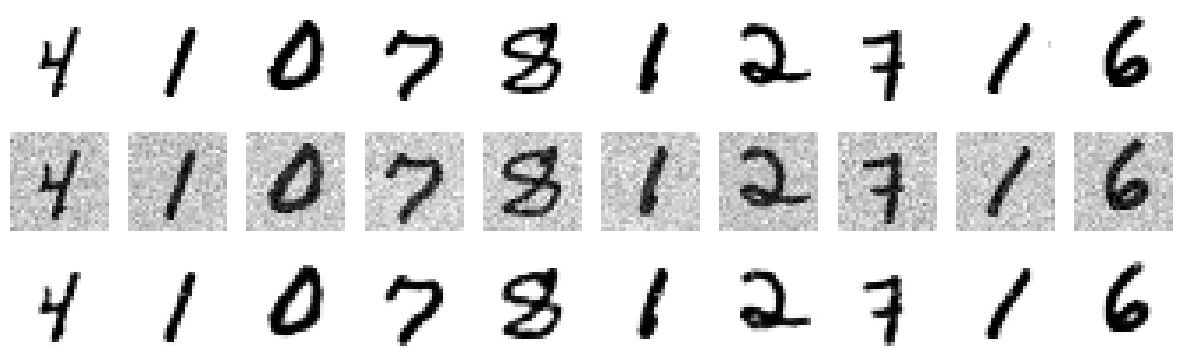

In [120]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def show_reconstructions(X, model, n_images=5):
    noisy_images = X[:n_images] + np.random.randn(n_images, 28, 28, 1) * 0.1
    reconstructions = model.predict(noisy_images)
    fig = plt.figure(figsize=(n_images * 1.5, 4.5))
    for image_index in range(n_images):
        plt.subplot(3, n_images, 1 + image_index)
        plot_image(X[image_index])

        plt.subplot(3, n_images, 1 + n_images + image_index)
        plot_image(noisy_images[image_index])

        plt.subplot(3, n_images, 1 + 2*n_images + image_index)
        plot_image(reconstructions[image_index])

show_reconstructions(X_train, gaussian_ae, 10)

In [122]:
for layer in gaussian_ae.layers[1].layers + gaussian_ae.layers[0].layers:
    layer.trainable = False

clf_model_pretrained = keras.models.Sequential([
    gaussian_ae.layers[0],
    gaussian_ae.layers[1],
    layers.Flatten(),
    layers.Dense(10, activation="softmax")
])
clf_model_pretrained.compile(optimizer=keras.optimizers.Nadam(),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

In [ ]:
filepath = time.strftime(f"{drive_path}/models/clf_%Y_%m_%d-%H_%M_%S")
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    filepath,
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch',
    initial_value_threshold=None
)
clf_model_pretrained.fit(X_train[:500], y_train[:500], epochs=10,
                         validation_data=(X_test, y_test),
                         callbacks=[checkpoint_cb])

In [ ]:
clf_model = keras.models.Sequential([
    layers.Flatten(input_shape=[28, 28, 1]),
    layers.Dense(10, activation="softmax")
])
clf_model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.1),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

In [ ]:
clf_model.fit(X_train[:500], y_train[:500], epochs=10,
                         validation_data=(X_test, y_test))

In [130]:
gaussian_ae.layers[0].summary()

Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise_19 (Gaussia  (None, 28, 28, 1)         0         
 nNoise)                                                         
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 14, 14, 16)        0         
 ng2D)                                                           
                                                                 
 flatten_23 (Flatten)        (None, 3136)              0         
                                                                 
 dense_66 (Dense)            (None, 400)               1254800   
                                                                 
Total params: 1254960 (4.79 MB)
Trainable params: 0 (

500/500 [==============================] - 4s 8ms/step


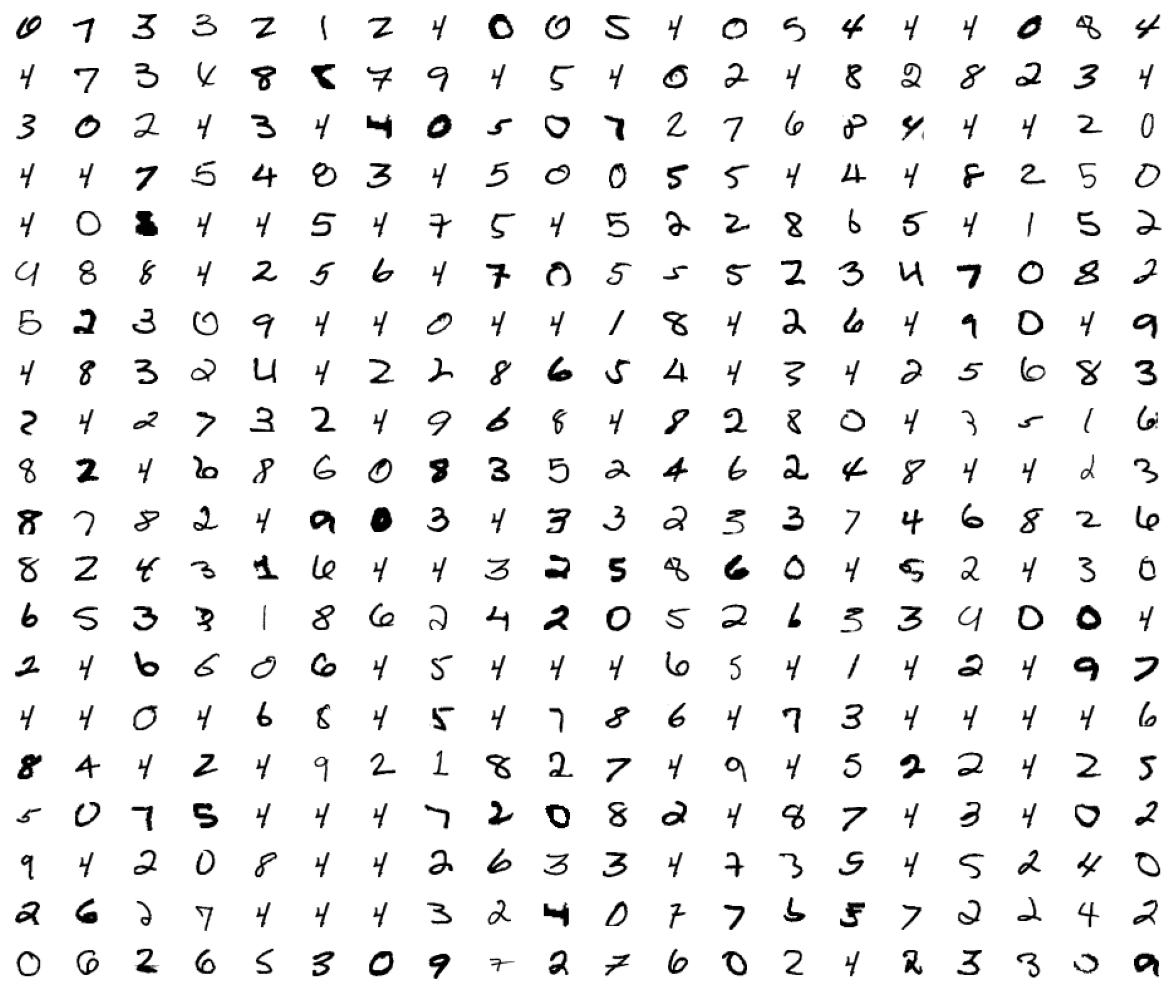

In [137]:
import numpy as np
import matplotlib.pyplot as plt


coding_layer_model = keras.models.Sequential([
    *gaussian_ae.layers[0].layers
])

activations = coding_layer_model.predict(X_train)

num_neurons = activations.shape[1]
max_activating_images = np.zeros((num_neurons, 28, 28, 1))

for neuron_idx in range(num_neurons):
    neuron_activations = activations[:, neuron_idx]
    max_activation_idx = np.argmax(neuron_activations)
    max_activating_images[neuron_idx] = X_train[max_activation_idx]


n_rows = 20
fig, axes = plt.subplots(n_rows, num_neurons // n_rows, figsize=(12, 10))
axes = axes.ravel()

for i in range(num_neurons):
    axes[i].imshow(max_activating_images[i].squeeze(), cmap='binary')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# 10.

In [24]:
train_set, test_set = tfds.load("mnist", as_supervised=True,
                                split=["train[:16000]", "test[:4000]"],
                                shuffle_files=True)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [25]:
X_train = np.array(list(train_set.map(lambda img, label: img/255).as_numpy_iterator()))
y_train = np.array(list(train_set.map(lambda img, label: label).as_numpy_iterator()))
X_test = np.array(list(test_set.map(lambda img, label: img/255).as_numpy_iterator()))
y_test = np.array(list(test_set.map(lambda img, label: label).as_numpy_iterator()))

In [26]:
K = keras.backend


class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

In [29]:
codings_size = 60
inputs = keras.layers.Input(shape=[28, 28, 1])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z) # μ
codings_log_var = keras.layers.Dense(codings_size)(z) # γ
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings]
)

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28*28*1, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28, 1])(x)
variational_decoder = keras.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1
)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [8]:
tf.config.run_functions_eagerly(True)

In [30]:
filepath = time.strftime(f"{drive_path}/models/variational_%Y_%m_%d-%H_%M_%S")
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    filepath,
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch',
    initial_value_threshold=None
)
variational_ae.fit(X_train, X_train, epochs=10,
                   validation_data=(X_test, X_test),
                   callbacks=[checkpoint_cb])

Epoch 1/10
500/500 [==============================] - 34s 68ms/step - loss: 0.2618 - val_loss: 0.2206
Epoch 2/10
500/500 [==============================] - 36s 73ms/step - loss: 0.2112 - val_loss: 0.2015
Epoch 3/10
500/500 [==============================] - 40s 81ms/step - loss: 0.1941 - val_loss: 0.1864
Epoch 4/10
500/500 [==============================] - 34s 69ms/step - loss: 0.1825 - val_loss: 0.1766
Epoch 5/10
500/500 [==============================] - 34s 68ms/step - loss: 0.1740 - val_loss: 0.1713
Epoch 6/10
500/500 [==============================] - 36s 72ms/step - loss: 0.1680 - val_loss: 0.1647
Epoch 7/10
500/500 [==============================] - 34s 68ms/step - loss: 0.1635 - val_loss: 0.1615
Epoch 8/10
500/500 [==============================] - 33s 66ms/step - loss: 0.1604 - val_loss: 0.1615
Epoch 9/10
500/500 [==============================] - 40s 80ms/step - loss: 0.1582 - val_loss: 0.1568
Epoch 10/10
500/500 [==============================] - 36s 73ms/step - loss: 0.156

In [31]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

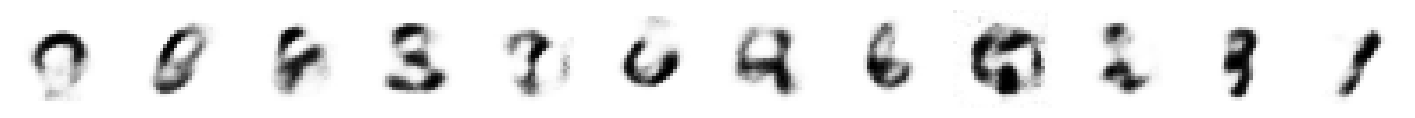

In [32]:
n_images = 12
codings = tf.random.normal(shape=[n_images, codings_size])
images = variational_decoder(codings).numpy()

fig = plt.figure(figsize=(n_images * 1.5, 1.5))
for image_index, image in enumerate(images):
    plt.subplot(1, n_images, 1 + image_index)
    plot_image(image)

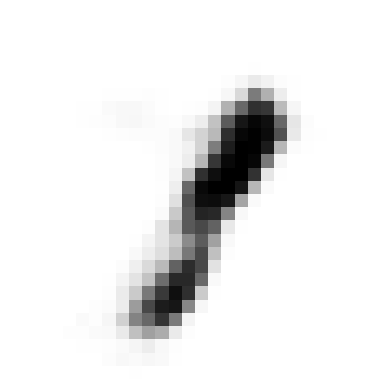

In [37]:
codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

for image in images:
    plot_image(image)

# 11.

In [38]:
train_set, test_set = tfds.load("mnist", as_supervised=True,
                                split=["train[:16000]", "test[:4000]"],
                                shuffle_files=True)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [ ]:
X_train = np.array(list(train_set.map(lambda img, label: img/255).as_numpy_iterator()))
y_train = np.array(list(train_set.map(lambda img, label: label).as_numpy_iterator()))
X_test = np.array(list(test_set.map(lambda img, label: img/255).as_numpy_iterator()))
y_test = np.array(list(test_set.map(lambda img, label: label).as_numpy_iterator()))

In [56]:
codings_size = 100
generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="same",
    activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="same",
    activation="tanh")
])
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="same",
    activation=keras.layers.LeakyReLU(0.2),
    input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="same",
    activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])
gan.compile(loss=keras.losses.BinaryCrossentropy(),
            optimizer=keras.optimizers.Adam())
discriminator.compile(loss=keras.losses.BinaryCrossentropy(),
                      optimizer=keras.optimizers.Adam())

In [52]:
img_train_set = train_set.map(lambda img, label: img/255)
img_train_set = img_train_set.map(
    lambda img: tf.reshape(img, [28, 28, 1]) * 2. - 1.
)
img_test_set = test_set.map(lambda img, label: img/255)
img_test_set = img_test_set.map(
    lambda img: tf.reshape(img, [28, 28, 1]) * 2. - 1.
)
img_train_set = img_train_set.shuffle(16000).batch(32).prefetch(1)
img_test_set = img_test_set.shuffle(16000).batch(32).prefetch(1)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [57]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=10):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print(epoch)
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)

train_gan(gan, img_train_set, 32, codings_size)

0
1
2


KeyboardInterrupt: 